In [3]:
%load_ext autoreload
%autoreload 2

import numpy as np
import ot

from vqr.data import generate_linear_x_y_mvn_data
from vqr.api import VectorQuantileRegressor
from vqr.vqr import RVQRDualLSESolver
from numpy.random import uniform, randint

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
d = 2
k = 2
n = 5000
X, Y_orig = generate_linear_x_y_mvn_data(n=n, d=d, k=k)

T = 50

U_samples = randint(0, T, size=(n, 2))

epsilon = 1e-5
vqr_ = VectorQuantileRegressor(
    n_levels=T,
    solver=RVQRDualLSESolver(
        verbose=True, num_epochs=1500, epsilon=epsilon, learning_rate=0.9
    ),
)
vqr_ = vqr_.fit(X, Y_orig)

A = vqr_._fitted_solution._A
B = vqr_._fitted_solution._B

epoch_idx=0, total_loss=2.339948 constraint_loss=2.239952, elapsed=0.26s
epoch_idx=100, total_loss=0.744075 constraint_loss=0.644073, elapsed=18.77s
epoch_idx=200, total_loss=0.601084 constraint_loss=0.501084, elapsed=17.40s
epoch_idx=300, total_loss=0.558365 constraint_loss=0.458365, elapsed=17.58s
Epoch 00383: reducing learning rate of group 0 to 4.5000e-01.
epoch_idx=400, total_loss=0.544559 constraint_loss=0.444559, elapsed=18.49s
Epoch 00484: reducing learning rate of group 0 to 2.2500e-01.
epoch_idx=500, total_loss=0.541645 constraint_loss=0.441645, elapsed=19.14s
Epoch 00585: reducing learning rate of group 0 to 1.1250e-01.
epoch_idx=600, total_loss=0.540638 constraint_loss=0.440638, elapsed=18.71s
Epoch 00686: reducing learning rate of group 0 to 5.6250e-02.
epoch_idx=700, total_loss=0.540205 constraint_loss=0.440205, elapsed=18.15s
Epoch 00787: reducing learning rate of group 0 to 2.8125e-02.
epoch_idx=800, total_loss=0.540014 constraint_loss=0.440014, elapsed=17.61s
Epoch 008

In [5]:
from vqr.vqr import decode_quantile_values
from numpy import zeros, array

# Sample X, Uniformly sample U to get Y

X_new = uniform(size=[n, k]) - 0.5
Y_samp = zeros([n, d])

for i in range(X.shape[0]):
    Y_hat = (B @ X_new[i, :][:, None]) + A
    Q1, Q2 = decode_quantile_values(T, d=2, Y_hat=Y_hat)
    u1, u2 = U_samples[i]
    Y_samp[i, :] = array((Q1[u1, u2], Q2[u1, u2]))


def U_to_colors(U_):
    U_ = np.concatenate([U_,np.zeros(shape=(U_.shape[0], 1))], axis=1)
    return U_/T

U_colors = U_to_colors(U_samples)
X_colors = np.concatenate([X_new+0.5, np.zeros(shape=(X_new.shape[0], 1))], axis=1)
colors = U_colors

In [6]:
def w2(Y_gt_, Y_est_):
    return ot.emd2(
        a=[],
        b=[],
        M=ot.dist(Y_gt_, Y_est_),
        numItermax=200_000,
        numThreads=8
    )


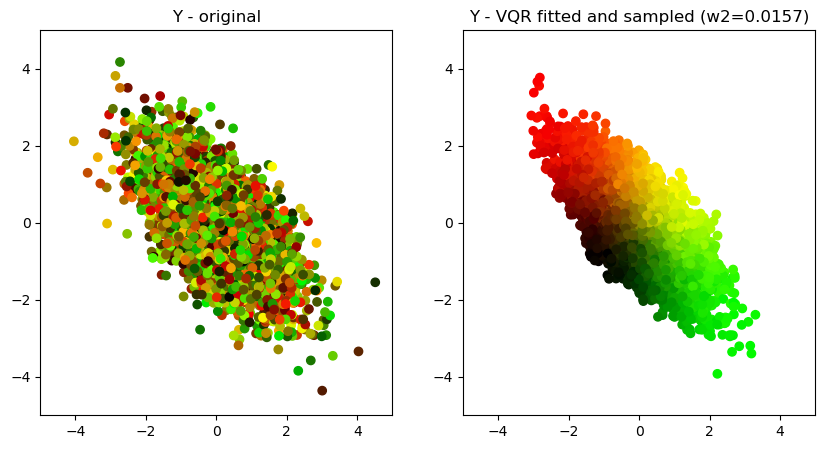

In [7]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].scatter(Y_orig[:, 0], Y_orig[:, 1], c=colors)
ax[0].set_title("Y - original")
ax[0].set_xlim(-5, 5)
ax[0].set_ylim(-5, 5)

ax[1].scatter(Y_samp[:, 0], Y_samp[:, 1], c=colors)
ax[1].set_title(f"Y - VQR fitted and sampled (w2={w2(Y_orig, Y_samp):.4f})")
ax[1].set_xlim(-5, 5)
ax[1].set_ylim(-5, 5)

plt.show()

In [13]:
# Generate a quantile function that is nonlinear in X

def g(x):
    # A nonlinear function in X
    Q = array([[10.0, 1.0], [1.0, 2.0]])
    return x.T @ Q @ x + x


Y_nl = zeros([n, d])
for i in range(n):
    # Sample using a known B but the quantile function is now nonlinear in X
    Y_hat = (B @ g(X_new[i, :][:, None])) + A
    Q1, Q2 = decode_quantile_values(T, d=2, Y_hat=Y_hat)
    u1, u2 = U_samples[i]
    Y_nl[i, :] = array((Q1[u1, u2], Q2[u1, u2]))


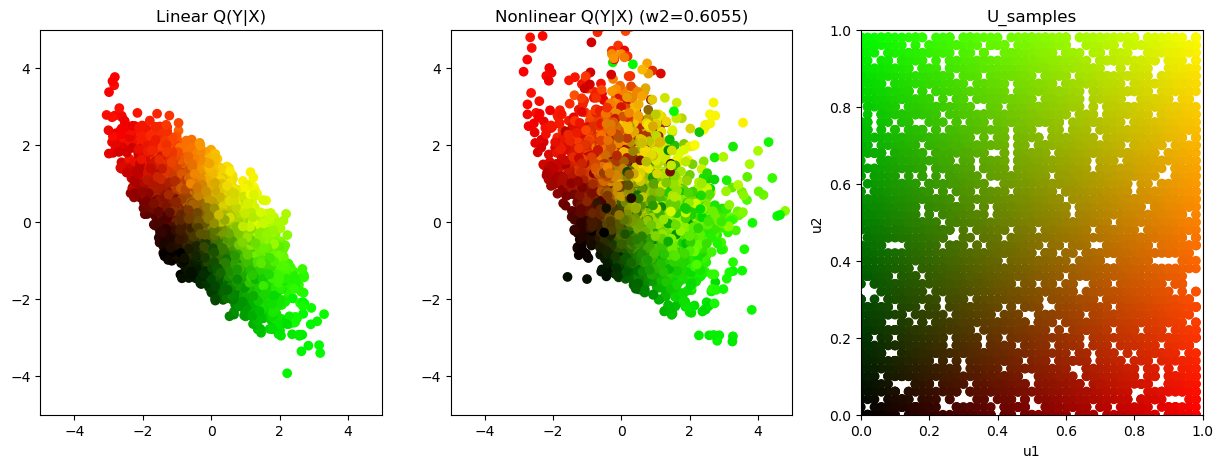

In [14]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

ax[0].scatter(Y_samp[:, 0], Y_samp[:, 1], c=colors)
ax[0].set_title("Linear Q(Y|X)")
ax[0].set_xlim(-5, 5)
ax[0].set_ylim(-5, 5)

ax[1].scatter(Y_nl[:, 0], Y_nl[:, 1], c=colors)
ax[1].set_title(f"Nonlinear Q(Y|X) (w2={w2(Y_samp, Y_nl):.4f})")
ax[1].set_xlim(-5, 5)
ax[1].set_ylim(-5, 5)

ax[2].scatter(U_samples[:, 0]/T, U_samples[:, 1]/T, c=U_colors)
ax[2].set_title("U_samples")
ax[2].set_xlim(0, 1); ax[2].set_xlabel("u1")
ax[2].set_ylim(0, 1); ax[2].set_ylabel("u2")

plt.show()

In [15]:
# We know that the distribution on the right has a nonlinear quantile function w.r.to X. 
# Now we fit a VQR on this data to get a linear approximation of this nonlinear function.
# This allows us to measure how mis-specified is the quantile function

vqr_approximating_nl = VectorQuantileRegressor(
    n_levels=T,
    solver=RVQRDualLSESolver(
        verbose=True, num_epochs=1500, epsilon=epsilon, learning_rate=0.9
    ),
)
vqr_approximating_nl = vqr_approximating_nl.fit(X_new, Y_nl)
B_approximating_nl = vqr_approximating_nl._fitted_solution._B
A_approximating_nl = vqr_approximating_nl._fitted_solution._A


epoch_idx=0, total_loss=4.382259 constraint_loss=4.282263, elapsed=0.19s
epoch_idx=100, total_loss=1.362494 constraint_loss=1.262492, elapsed=17.49s
epoch_idx=200, total_loss=1.129197 constraint_loss=1.029198, elapsed=18.14s
epoch_idx=300, total_loss=1.053520 constraint_loss=0.953521, elapsed=18.22s
Epoch 00383: reducing learning rate of group 0 to 4.5000e-01.
epoch_idx=400, total_loss=1.026061 constraint_loss=0.926060, elapsed=17.25s
Epoch 00484: reducing learning rate of group 0 to 2.2500e-01.
epoch_idx=500, total_loss=1.020134 constraint_loss=0.920134, elapsed=17.83s
Epoch 00585: reducing learning rate of group 0 to 1.1250e-01.
epoch_idx=600, total_loss=1.018325 constraint_loss=0.918325, elapsed=17.52s
Epoch 00686: reducing learning rate of group 0 to 5.6250e-02.
epoch_idx=700, total_loss=1.017632 constraint_loss=0.917632, elapsed=17.55s
Epoch 00787: reducing learning rate of group 0 to 2.8125e-02.
epoch_idx=800, total_loss=1.017339 constraint_loss=0.917339, elapsed=17.74s
Epoch 008

In [17]:
Y_approximated_nl = zeros([n, d])
for i in range(n):
    # Y_hat = (B_approximating_nl @ g(X_new[i, :][:, None])) + A_approximating_nl
    Y_hat = (B_approximating_nl @ X_new[i, :][:, None]) + A_approximating_nl
    Q1, Q2 = decode_quantile_values(T, d=2, Y_hat=Y_hat)
    u1, u2 = U_samples[i]
    Y_approximated_nl[i, :] = array((Q1[u1, u2], Q2[u1, u2]))

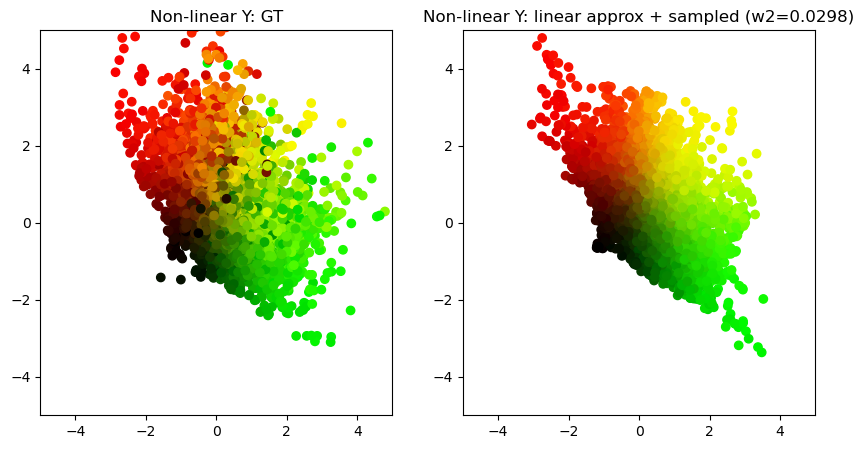

In [18]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].scatter(Y_nl[:, 0], Y_nl[:, 1], c=colors)
ax[0].set_title("Non-linear Y: GT")
ax[0].set_xlim(-5, 5)
ax[0].set_ylim(-5, 5)

ax[1].scatter(Y_approximated_nl[:, 0], Y_approximated_nl[:, 1], c=colors)
ax[1].set_title(f"Non-linear Y: linear approx + sampled "
                f"(w2={w2(Y_nl, Y_approximated_nl):.4f})")
ax[1].set_xlim(-5, 5)
ax[1].set_ylim(-5, 5)

plt.show()

In [19]:
from numpy import stack

nonlinear_vqr_gt = VectorQuantileRegressor(
    n_levels=T,
    solver=RVQRDualLSESolver(
        verbose=True, num_epochs=1500, epsilon=epsilon, learning_rate=0.9
    ),
)
nonlinear_vqr_gt = nonlinear_vqr_gt.fit(
    stack([g(X_new[i, :]) for i in range(n)]), Y_nl
)
B_nl_gt = nonlinear_vqr_gt._fitted_solution._B
A_nl_gt = nonlinear_vqr_gt._fitted_solution._A


epoch_idx=0, total_loss=4.382259 constraint_loss=4.282263, elapsed=0.19s
epoch_idx=100, total_loss=0.569127 constraint_loss=0.469124, elapsed=18.01s
epoch_idx=200, total_loss=0.213437 constraint_loss=0.113437, elapsed=17.85s
epoch_idx=300, total_loss=-0.036334 constraint_loss=-0.136332, elapsed=20.70s
epoch_idx=400, total_loss=-0.271079 constraint_loss=-0.371079, elapsed=25.15s
epoch_idx=500, total_loss=-0.502959 constraint_loss=-0.602960, elapsed=25.04s
epoch_idx=600, total_loss=-0.733918 constraint_loss=-0.833919, elapsed=29.15s
epoch_idx=700, total_loss=-0.964545 constraint_loss=-1.064547, elapsed=29.70s
epoch_idx=800, total_loss=-1.194849 constraint_loss=-1.294851, elapsed=30.45s
epoch_idx=900, total_loss=-1.425042 constraint_loss=-1.525047, elapsed=29.86s
epoch_idx=1000, total_loss=-1.654933 constraint_loss=-1.754939, elapsed=30.29s
epoch_idx=1100, total_loss=-1.884925 constraint_loss=-1.984932, elapsed=30.18s
epoch_idx=1200, total_loss=-2.114621 constraint_loss=-2.214630, elapsed

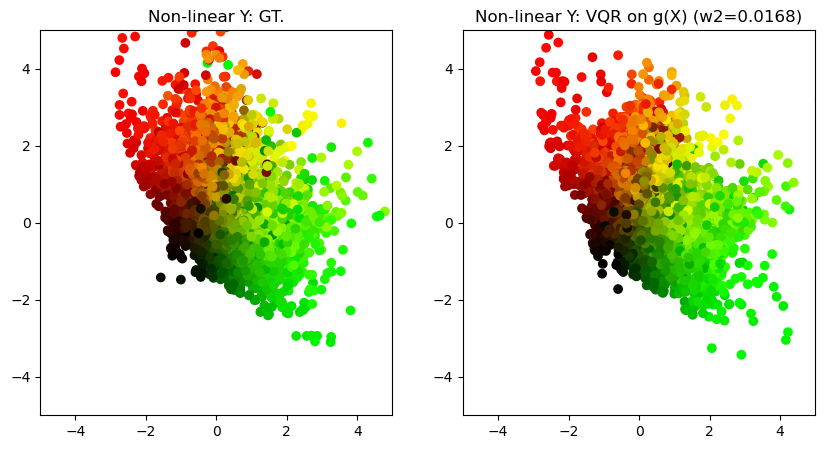

In [21]:
Y_nl_gt = zeros([n, d])
for i in range(n):
    Y_hat = (B_nl_gt @ g(X_new[i, :][:, None])) + A_nl_gt
    Q1, Q2 = decode_quantile_values(T, d=2, Y_hat=Y_hat)
    u1, u2 = U_samples[i]
    Y_nl_gt[i, :] = array((Q1[u1, u2], Q2[u1, u2]))

fig, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].scatter(Y_nl[:, 0], Y_nl[:, 1], c=colors)
ax[0].set_title("Non-linear Y: GT.")
ax[0].set_xlim(-5, 5)
ax[0].set_ylim(-5, 5)

ax[1].scatter(Y_nl_gt[:, 0], Y_nl_gt[:, 1], c=colors)
ax[1].set_title(f"Non-linear Y: VQR on g(X) (w2={w2(Y_nl, Y_nl_gt):.4f})")
ax[1].set_xlim(-5, 5)
ax[1].set_ylim(-5, 5)

plt.show()

In [16]:
from vqr.vqr import NonlinearRVQRDualLSESolver
import pickle

with open("nonlin-y.pkl", "wb") as f:
    pickle.dump({'X': X_new, 'Y': Y_nl, 'U_samples': U_samples, 'colors': colors}, f)